# Training FDFL

In [33]:
import sys
import warnings
import time
import copy
import json
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cvxpy as cp

from pyepo.model.opt import optModel
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\FDFL\\helper')
sys.path.insert(0, 'E:\\User\\Stevens\\MyRepo\\fold-opt-package\\fold_opt')

from myutil import *
from features import get_all_features

# Suppress warnings
warnings.filterwarnings("ignore")
from GMRES import *
from fold_opt import *

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)


cpu


### Import and Process Data

Running with simpler model
Alpha = 0.5, 1.5, 2, 3

In [34]:
alpha, Q = 0.5, 1000

In [35]:
df = pd.read_csv('data/data.csv')
# fix random seed for reproducibility

# report statistics on this dataset
df = df.sample(n=5000, random_state=1)

columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
#df['risk_score_t'] = df['risk_score_t'].apply(lambda x: 0.1 if x < 0.1 else x)
df['g_continuous'] = df['g_continuous'].apply(lambda x: 0.1 if x < 0.1 else x)


risk = df['risk_score_t'].values
risk = risk + 0.001 if 0 in risk else risk


feats = df[get_all_features(df)].values
gainF = df['g_continuous'].values
decision = df['propensity_score'].values
cost = np.random.normal(1, 0.5, len(risk)).clip(0.1, 2)
race = df['race'].values

# transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

from sklearn.model_selection import train_test_split



In [36]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race, alpha=alpha, Q=Q):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()
        self.optmodel = optmodel

        # Solve for w*, z* using separate risk and gainF # Ensure a separate instance
        self.w_star, self.z_star = self.optmodel(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star


In [37]:
# class FairRiskPredictor(nn.Module):
#     def __init__(self, input_dim, dropout_rate=0.1):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 1),
#             nn.Softplus()
#         )
            
                    
#     def forward(self, x):
#         return self.model(x).squeeze(-1)
    
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # First layer with batch normalization
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(64, 1),
            nn.Softplus()
        )
            
    def forward(self, x):
        return self.model(x).squeeze(-1)

In [38]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, race, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(), opt_sol.cuda(), opt_val.cuda()

    with torch.no_grad():
        pred_risk = predmodel(feats)

    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy().flatten()
    pred_risk = pred_risk.clip(min=0.001)
    gainF = gainF.detach().to('cpu').numpy().flatten()
    cost = cost.detach().to('cpu').numpy().flatten()
    pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)

    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)
    predmodel.train()
    return normalized_regret

# Helper Functions

In [39]:
# Setup training parameters

optmodel = solve_closed_form

# Perform train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, df['race'].values, test_size=0.5, random_state=2
)

print(f"Train size: {feats_train.shape[0]}")
print(f"Test size: {feats_test.shape[0]}")

dataset_train = optDataset(optmodel, feats_train, risk_train, gainF_train, cost_train, race_train, alpha=alpha, Q=Q)
dataset_test = optDataset(optmodel, feats_test, risk_test, gainF_test, cost_test, race_test, alpha=alpha, Q=Q)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)
# save the initial model
# torch.save(predmodel.state_dict(), 'initial_model.pth')
# load the initial model

Train size: 2500
Test size: 2500


FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=149, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Softplus(beta=1, threshold=20)
  )
)

In [40]:
import time
import torch
import torch.nn as nn

# assume make_foldopt_layer and alpha_fair are already in scope from your fold-opt code
# from fold_opt import make_foldopt_layer, alpha_fair

def trainFairModelFoldOpt(
    predmodel,
    loader_train,
    loader_test,
    alpha,
    Q,
    lambda_fairness=0.1,
    num_epochs=10,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES"
):
    device = next(predmodel.parameters()).device
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr_pred, weight_decay=weight_decay)

    logs = {
        "train_loss": [],
        "train_mse": [],
        "train_fair": [],
        "train_regret": []
    }

    predmodel.train()
    for epoch in range(1, num_epochs + 1):
        t0 = time.time()

        # --- pull the one-and-only batch (the entire dataset) ---
        feats, risk, gainF, cost, race, opt_d, opt_obj = next(iter(loader_train))

        # squeeze away the dummy batch‐dim and move to device
        feats   = feats.squeeze(0).to(device)   # (n,m)
        risk    = risk.squeeze(0).to(device)    # (n)
        gainF   = gainF.squeeze(0).to(device)   # (n)
        cost    = cost.squeeze(0).to(device)    # (n)
        race    = race.squeeze(0).to(device)    # (n)
        opt_d   = opt_d.squeeze(0).to(device)   # (n)
        opt_obj = opt_obj.squeeze(0).to(device) # scalar or (1)

        # --- forward pass: predict risk ---
        pred_risk = predmodel(feats).clamp(min=1e-3)  # (n,)

        # --- build a Fold-Opt layer for this batch ---
        #    it will map r_batch (1,n) → d_pred (1,n)
        fold_layer = make_foldopt_layer(
            gainF, cost, alpha, Q,
            lr=pgd_lr,
            n_fixedpt=n_fixedpt,
            rule=backprop_rule
        )

        # run it (we need a 2-d input for the layer)
        d_pred = fold_layer(pred_risk.unsqueeze(0)).squeeze(0)  # (n,)
        # d_pred = proj_budget(d_pred, cost, Q, max_iter=500).clamp(min=0.)

        # used = cost.to(d_pred.device) @ d_pred
        # if used > Q + 1e-6:
        #     print(f"[WARN] budget overshoot: {used - Q:.2e}")
        # assert used <= Q + 1e-6

        # --- compute regret loss via alpha‐fairness ---
        u_pred    = d_pred * risk * gainF               # (n,)
        pred_obj  = alpha_fair(u_pred.unsqueeze(0), alpha)       # scalar

        regret_l1 = (opt_obj - pred_obj) / (opt_obj.abs() + 1e-7)  # (1,)

        # --- fairness penalty: difference in MSE across race groups ---
        m0 = (pred_risk[race == 0] - risk[race == 0]).pow(2).mean() if (race==0).any() else torch.tensor(0., device=device)
        m1 = (pred_risk[race == 1] - risk[race == 1]).pow(2).mean() if (race==1).any() else torch.tensor(0., device=device)
        fair_reg = torch.abs(m0 - m1)

        # --- total loss & backward ---
        loss = regret_l1 + lambda_fairness * fair_reg
        loss.to(device)  # move to device
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- compute simple MSE for logging ---
        mse_train = (pred_risk - risk).pow(2).mean()

        # --- log everything ---
        logs["train_loss"].append(loss.item())
        logs["train_mse"].append(mse_train.item())
        logs["train_fair"].append(fair_reg.item())
        logs["train_regret"].append(regret_l1.item())

        # (optional) print progress
        if epoch % 1 == 0:
            print(f"Epoch {epoch:2d} | Loss={loss.item():.4f} | MSE={mse_train.item():.4f} | Fair={fair_reg.item():.4f} | Regret={regret_l1.item():.4f} | {time.time()-t0:.1f}s")

    predmodel.eval()
    return logs


In [41]:
import time
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def run_multiple_trials_foldopt(
    feats,
    gainF,
    risk,
    cost,
    df,
    optmodel,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=0.0,
    num_epochs=50,
    lr_pred=5e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=2,
    Q=1000,
    device="cpu"
):
    """
    Runs multiple random-split trials of fold-opt DFL training, collects 
    TRAINING curves, and plots mean ± 1 std over trials for Loss, Regret, 
    MSE, and Fairness.
    """
    all_loss   = []
    all_regret = []
    all_mse    = []
    all_fair   = []
    times      = []

    start_all = time.time()
    for t in range(n_trials):
        # print(f"[Trial {t+1}/{n_trials}]")
        t0 = time.time()

        # 1) random train/test split
        split = train_test_split(
            feats, gainF, risk, cost, df['race'].values,
            test_size=test_size, random_state=t
        )
        feats_tr, feats_te, g_tr, g_te, r_tr, r_te, c_tr, c_te, race_tr, race_te = split

        # 2) build datasets / loaders
        ds_tr = optDataset(optmodel, feats_tr, r_tr, g_tr, c_tr, race_tr, alpha=alpha, Q=Q)
        loader_tr = DataLoader(ds_tr, batch_size=1, shuffle=False)

        # 3) init predictor
        pred = FairRiskPredictor(feats_tr.shape[1]).to(device)

        # 4) train fold-opt
        logs = trainFairModelFoldOpt(
            predmodel=pred,
            loader_train=loader_tr,
            loader_test=None,            # ignored by this function
            alpha=alpha,
            Q=Q,
            lambda_fairness=lambda_fairness,
            num_epochs=num_epochs,
            lr_pred=lr_pred,
            weight_decay=weight_decay,
            pgd_lr=pgd_lr,
            n_fixedpt=n_fixedpt,
            backprop_rule=backprop_rule
        )

        all_loss.append(logs["train_loss"])
        all_regret.append(logs["train_regret"])
        all_mse.append(logs["train_mse"])
        all_fair.append(logs["train_fair"])

        times.append(time.time() - t0)

    total_time = time.time() - start_all
    mean_time, std_time = np.mean(times), np.std(times)
    print(f"\nAll {n_trials} trials done in {total_time:.1f}s  (avg {mean_time:.1f}±{std_time:.1f}s each)")

    # to arrays: shape (n_trials, num_epochs)
    all_loss   = np.array(all_loss)
    all_regret = np.array(all_regret)
    all_mse    = np.array(all_mse)
    all_fair   = np.array(all_fair)
    epochs     = np.arange(all_loss.shape[1])

    # compute mean ± std
    m_loss,   s_loss   = all_loss.mean(0),   all_loss.std(0)
    m_regret, s_regret = all_regret.mean(0), all_regret.std(0)
    m_mse,    s_mse    = all_mse.mean(0),    all_mse.std(0)
    m_fair,   s_fair   = all_fair.mean(0),   all_fair.std(0)

    # --- plot ---
    fig, axes = plt.subplots(1,4, figsize=(24,4))
    titles = ["Training Loss","Training Regret","Training MSE","Training Fairness"]
    means  = [m_loss, m_regret, m_mse, m_fair]
    stds   = [s_loss, s_regret, s_mse, s_fair]
    colors = ["C0","C1","C2","C3"]

    for ax, title, mean, std, col in zip(axes, titles, means, stds, colors):
        ax.plot(epochs, mean,   color=col, lw=2)
        ax.fill_between(epochs,
                        mean - std,
                        mean + std,
                        color=col, alpha=0.2)
        ax.set_title(f"{title}\n(avg of {n_trials} trials)", fontsize=14)
        ax.set_xlabel("Epoch", fontsize=12)
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "mean_train_loss":     m_loss,
        "std_train_loss":      s_loss,
        "mean_train_regret":   m_regret,
        "std_train_regret":    s_regret,
        "mean_train_mse":      m_mse,
        "std_train_mse":       s_mse,
        "mean_train_fair":     m_fair,
        "std_train_fair":      s_fair,
        "times":               times,
        "total_time":          total_time,
        "mean_time":           mean_time,
        "std_time":            std_time,
    }


Epoch  1 | Loss=17.3020 | MSE=53.2174 | Fair=45.3348 | Regret=17.3020 | 1.6s
Epoch  2 | Loss=16.6510 | MSE=53.1531 | Fair=44.9539 | Regret=16.6510 | 1.6s
Epoch  3 | Loss=15.7452 | MSE=53.0806 | Fair=44.6618 | Regret=15.7452 | 1.6s
Epoch  4 | Loss=15.4746 | MSE=52.9862 | Fair=44.8097 | Regret=15.4746 | 1.6s
Epoch  5 | Loss=14.5522 | MSE=52.8952 | Fair=44.6325 | Regret=14.5522 | 1.6s
Epoch  6 | Loss=14.0069 | MSE=52.8036 | Fair=44.4265 | Regret=14.0069 | 1.6s
Epoch  7 | Loss=13.3773 | MSE=52.7303 | Fair=44.0200 | Regret=13.3773 | 1.6s
Epoch  8 | Loss=12.9368 | MSE=52.6550 | Fair=44.1012 | Regret=12.9368 | 1.6s
Epoch  9 | Loss=12.4657 | MSE=52.5882 | Fair=43.5986 | Regret=12.4657 | 1.7s
Epoch 10 | Loss=12.1814 | MSE=52.4854 | Fair=43.3945 | Regret=12.1814 | 1.7s
Epoch 11 | Loss=11.5605 | MSE=52.4416 | Fair=43.2409 | Regret=11.5605 | 1.6s
Epoch 12 | Loss=11.1302 | MSE=52.4402 | Fair=43.7859 | Regret=11.1302 | 1.6s
Epoch 13 | Loss=10.6406 | MSE=52.2932 | Fair=43.1234 | Regret=10.6406 | 1.8s

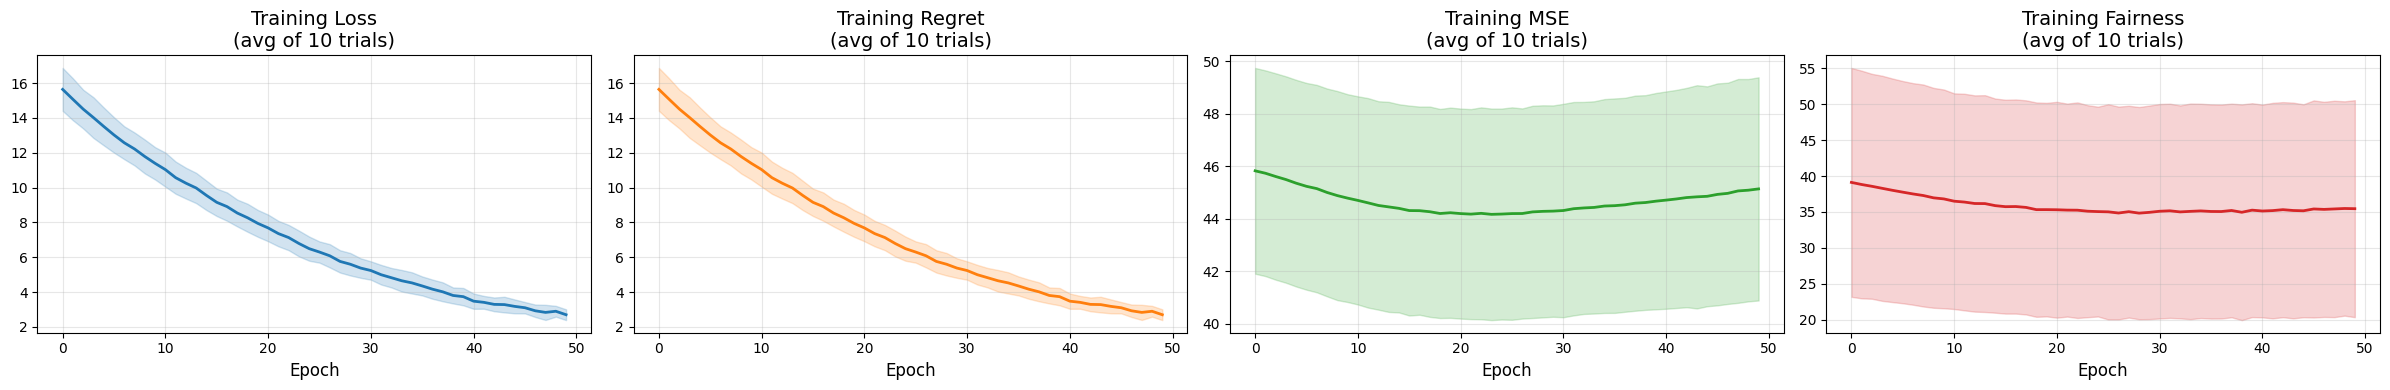

In [42]:
results_2 = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=0,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=2,
    Q=1000,
    device="cpu"
)

Epoch  1 | Loss=0.3359 | MSE=49.3898 | Fair=44.1775 | Regret=0.3359 | 1.9s
Epoch  2 | Loss=0.3302 | MSE=49.5948 | Fair=43.7509 | Regret=0.3302 | 1.9s
Epoch  3 | Loss=0.3303 | MSE=49.7447 | Fair=44.3950 | Regret=0.3303 | 1.9s
Epoch  4 | Loss=0.3345 | MSE=49.7934 | Fair=44.5075 | Regret=0.3345 | 1.9s
Epoch  5 | Loss=0.3369 | MSE=49.8477 | Fair=44.6804 | Regret=0.3369 | 1.9s
Epoch  6 | Loss=0.3318 | MSE=49.7735 | Fair=44.5877 | Regret=0.3318 | 1.9s
Epoch  7 | Loss=0.3358 | MSE=49.8095 | Fair=44.5286 | Regret=0.3358 | 1.9s
Epoch  8 | Loss=0.3303 | MSE=49.8192 | Fair=44.5324 | Regret=0.3303 | 1.9s
Epoch  9 | Loss=0.3352 | MSE=49.7300 | Fair=44.1003 | Regret=0.3352 | 1.9s
Epoch 10 | Loss=0.3340 | MSE=49.7076 | Fair=44.3838 | Regret=0.3340 | 1.9s
Epoch 11 | Loss=0.3367 | MSE=49.6870 | Fair=44.1207 | Regret=0.3367 | 2.0s
Epoch 12 | Loss=0.3324 | MSE=49.6570 | Fair=44.2067 | Regret=0.3324 | 2.0s
Epoch 13 | Loss=0.3339 | MSE=49.6804 | Fair=44.2967 | Regret=0.3339 | 2.0s
Epoch 14 | Loss=0.3349 | 

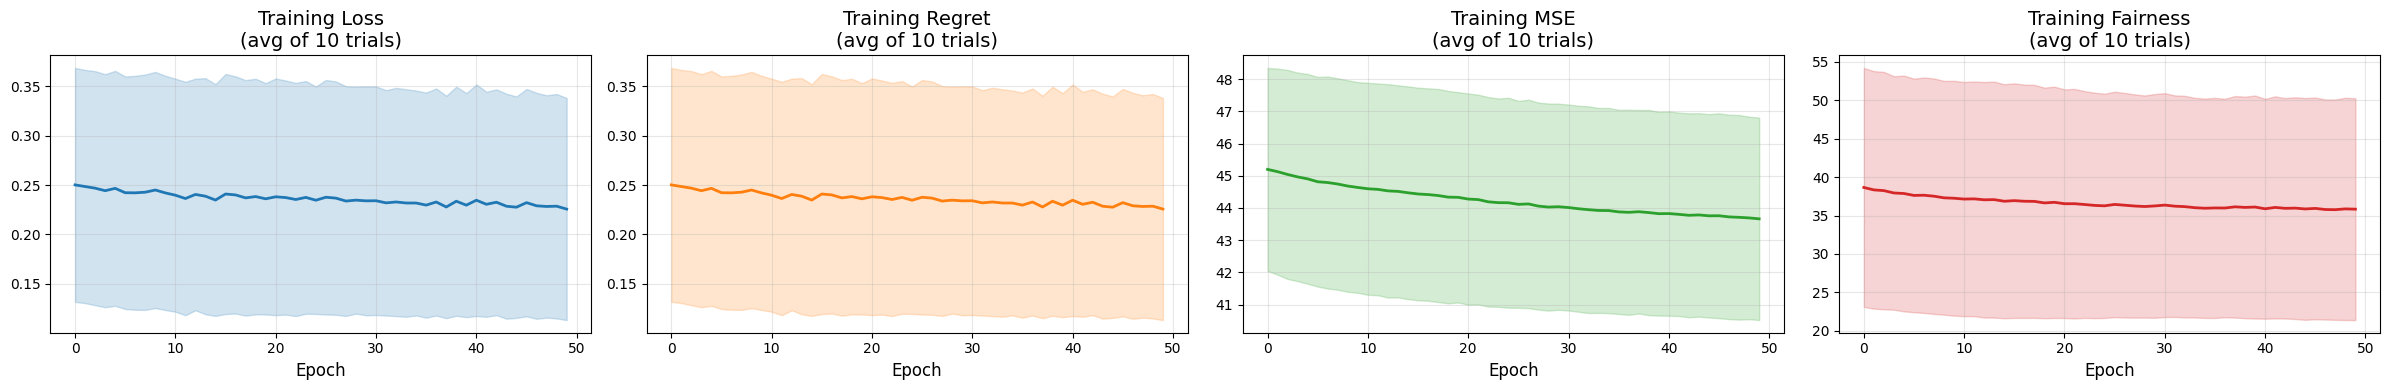

In [43]:
results_0p5 = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=0,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=0.5,
    Q=1000,
    device="cpu"
)

Epoch  1 | Loss=0.4581 | MSE=50.3316 | Fair=43.8967 | Regret=0.4581 | 1.0s
Epoch  2 | Loss=0.4527 | MSE=50.3195 | Fair=43.4447 | Regret=0.4527 | 1.0s
Epoch  3 | Loss=0.4471 | MSE=50.3333 | Fair=43.4023 | Regret=0.4471 | 1.0s
Epoch  4 | Loss=0.4409 | MSE=50.3887 | Fair=43.5594 | Regret=0.4409 | 1.0s
Epoch  5 | Loss=0.4365 | MSE=50.4357 | Fair=43.2465 | Regret=0.4365 | 1.0s
Epoch  6 | Loss=0.4316 | MSE=50.4415 | Fair=43.0485 | Regret=0.4316 | 1.0s
Epoch  7 | Loss=0.4279 | MSE=50.4737 | Fair=42.7642 | Regret=0.4279 | 1.0s
Epoch  8 | Loss=0.4251 | MSE=50.5110 | Fair=43.1556 | Regret=0.4251 | 1.0s
Epoch  9 | Loss=0.4201 | MSE=50.6143 | Fair=42.6737 | Regret=0.4201 | 1.0s
Epoch 10 | Loss=0.4158 | MSE=50.5967 | Fair=42.0841 | Regret=0.4158 | 1.0s
Epoch 11 | Loss=0.4115 | MSE=50.7884 | Fair=42.9059 | Regret=0.4115 | 1.0s
Epoch 12 | Loss=0.4073 | MSE=50.9573 | Fair=42.6910 | Regret=0.4073 | 1.0s
Epoch 13 | Loss=0.4018 | MSE=51.0754 | Fair=43.0063 | Regret=0.4018 | 1.0s
Epoch 14 | Loss=0.4016 | 

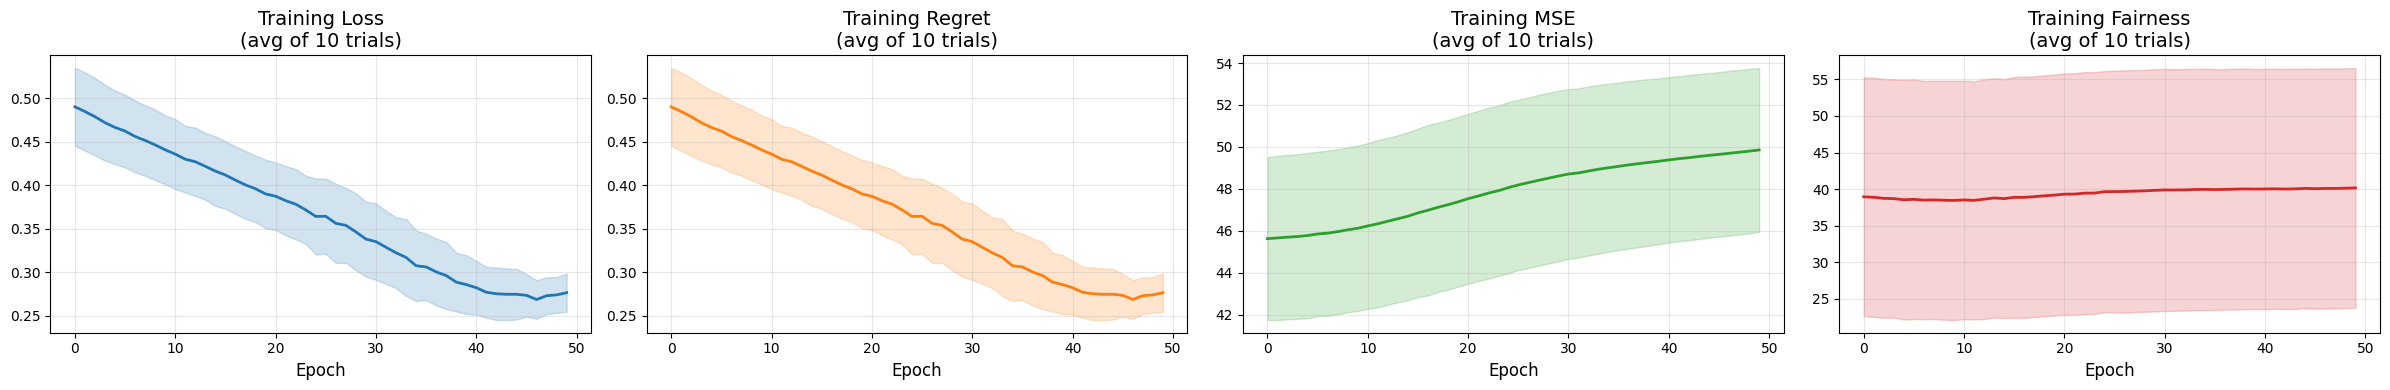

In [44]:
results_1p5 = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=0,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=1.5,
    Q=1000,
    device="cpu"
)

Epoch  1 | Loss=60.3919 | MSE=51.4159 | Fair=44.8617 | Regret=15.5302 | 1.8s
Epoch  2 | Loss=59.5152 | MSE=51.2441 | Fair=44.5656 | Regret=14.9496 | 1.8s
Epoch  3 | Loss=58.3976 | MSE=50.9580 | Fair=44.0987 | Regret=14.2988 | 1.8s
Epoch  4 | Loss=56.4919 | MSE=50.6893 | Fair=42.8797 | Regret=13.6122 | 1.8s
Epoch  5 | Loss=55.8254 | MSE=50.5003 | Fair=42.5398 | Regret=13.2856 | 1.8s
Epoch  6 | Loss=54.4980 | MSE=50.1839 | Fair=41.8244 | Regret=12.6736 | 1.8s
Epoch  7 | Loss=53.4983 | MSE=49.8974 | Fair=41.1656 | Regret=12.3327 | 1.8s
Epoch  8 | Loss=52.2745 | MSE=49.6134 | Fair=40.5566 | Regret=11.7179 | 1.8s
Epoch  9 | Loss=50.7310 | MSE=49.2466 | Fair=39.3785 | Regret=11.3524 | 1.8s
Epoch 10 | Loss=49.9611 | MSE=49.0497 | Fair=39.1266 | Regret=10.8345 | 1.8s
Epoch 11 | Loss=48.9232 | MSE=48.7061 | Fair=38.3356 | Regret=10.5876 | 1.8s
Epoch 12 | Loss=46.7695 | MSE=48.2568 | Fair=36.6784 | Regret=10.0912 | 1.8s
Epoch 13 | Loss=46.2461 | MSE=48.0649 | Fair=36.3950 | Regret=9.8511 | 1.8s


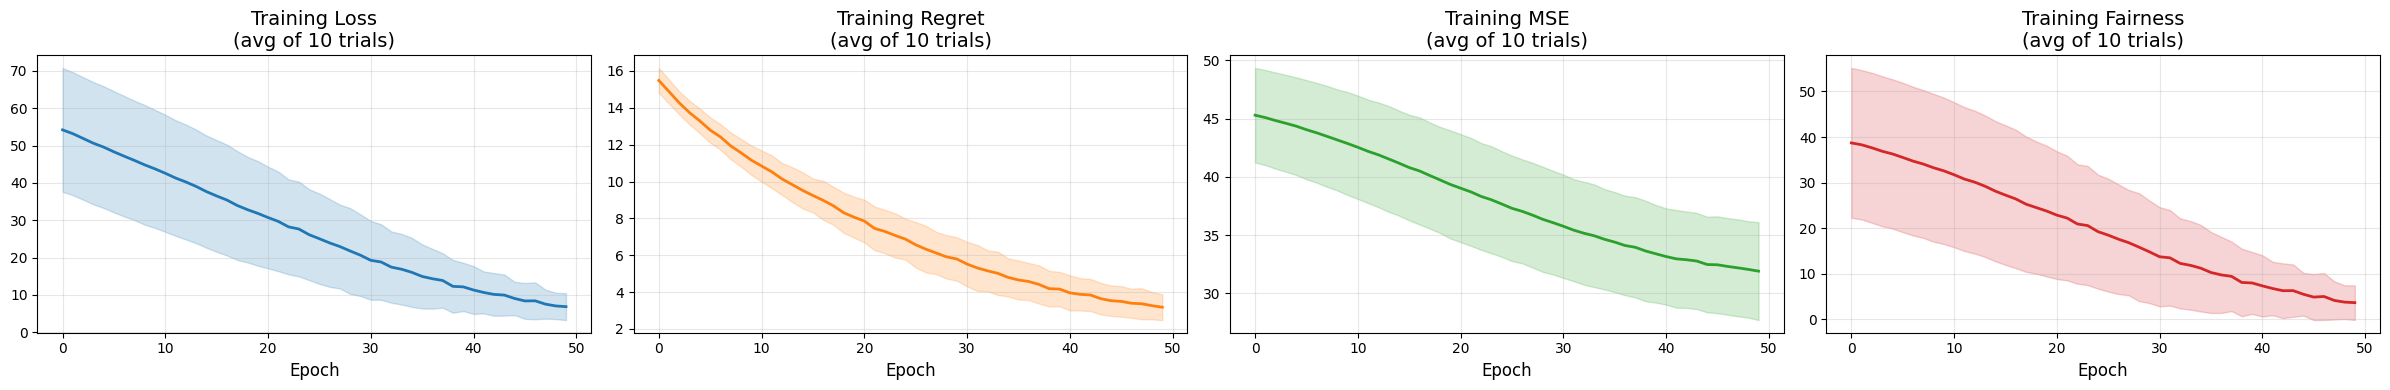

Epoch  1 | Loss=45.2291 | MSE=51.4643 | Fair=44.7665 | Regret=0.4626 | 1.0s
Epoch  2 | Loss=44.8206 | MSE=51.2081 | Fair=44.3625 | Regret=0.4581 | 1.0s
Epoch  3 | Loss=44.0962 | MSE=51.0163 | Fair=43.6403 | Regret=0.4559 | 1.0s
Epoch  4 | Loss=43.4374 | MSE=50.8259 | Fair=42.9847 | Regret=0.4527 | 1.0s
Epoch  5 | Loss=43.0400 | MSE=50.5568 | Fair=42.5920 | Regret=0.4480 | 1.0s
Epoch  6 | Loss=42.2768 | MSE=50.2759 | Fair=41.8315 | Regret=0.4453 | 1.0s
Epoch  7 | Loss=41.4496 | MSE=50.0303 | Fair=41.0089 | Regret=0.4407 | 1.0s
Epoch  8 | Loss=40.7705 | MSE=49.7361 | Fair=40.3311 | Regret=0.4393 | 1.0s
Epoch  9 | Loss=39.9225 | MSE=49.3869 | Fair=39.4872 | Regret=0.4352 | 1.0s
Epoch 10 | Loss=39.3863 | MSE=49.0751 | Fair=38.9516 | Regret=0.4347 | 1.0s
Epoch 11 | Loss=38.8226 | MSE=48.8874 | Fair=38.3914 | Regret=0.4312 | 1.0s
Epoch 12 | Loss=37.5389 | MSE=48.4803 | Fair=37.1090 | Regret=0.4299 | 1.0s
Epoch 13 | Loss=36.5882 | MSE=48.0567 | Fair=36.1601 | Regret=0.4282 | 1.0s
Epoch 14 | L

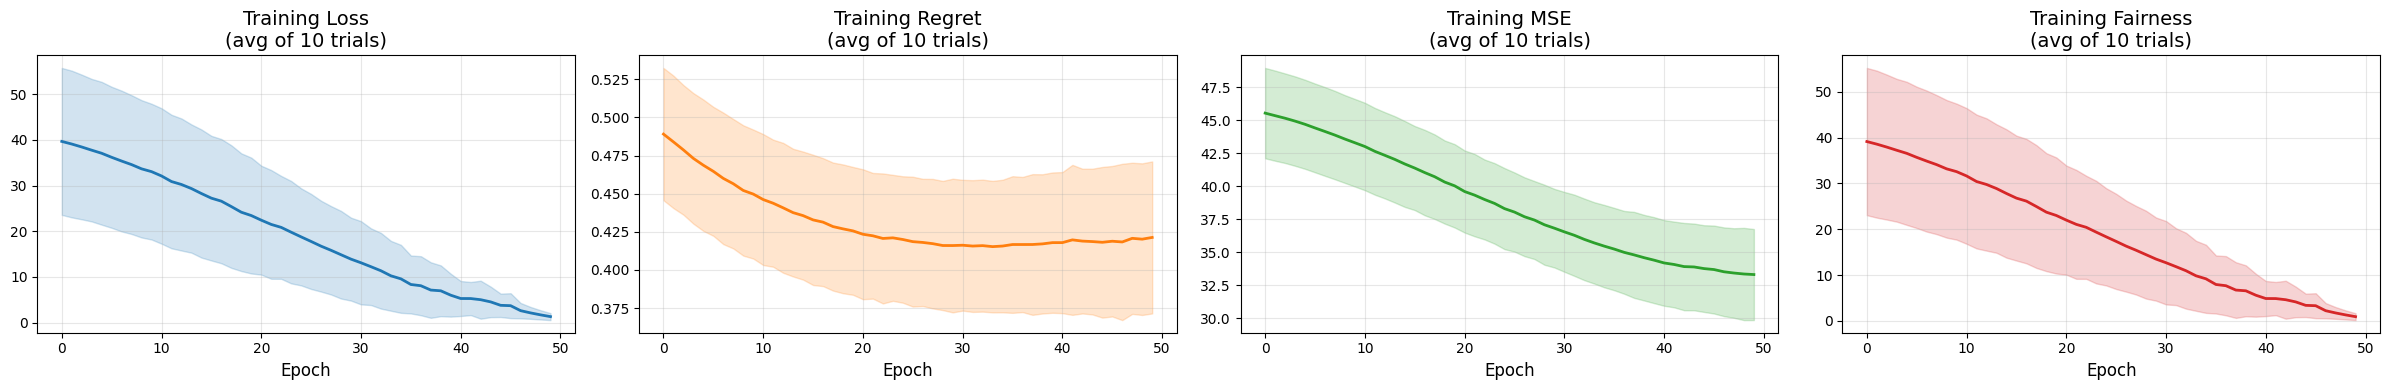

Epoch  1 | Loss=45.6847 | MSE=52.0684 | Fair=45.3626 | Regret=0.3221 | 1.7s
Epoch  2 | Loss=45.1062 | MSE=51.8764 | Fair=44.7849 | Regret=0.3212 | 1.8s
Epoch  3 | Loss=45.0315 | MSE=51.7861 | Fair=44.7107 | Regret=0.3208 | 1.8s
Epoch  4 | Loss=44.4770 | MSE=51.5894 | Fair=44.1590 | Regret=0.3179 | 1.8s
Epoch  5 | Loss=44.0705 | MSE=51.4046 | Fair=43.7532 | Regret=0.3173 | 1.8s
Epoch  6 | Loss=43.4756 | MSE=51.2893 | Fair=43.1540 | Regret=0.3216 | 1.8s
Epoch  7 | Loss=42.9536 | MSE=51.0662 | Fair=42.6340 | Regret=0.3197 | 1.7s
Epoch  8 | Loss=42.3759 | MSE=50.8720 | Fair=42.0516 | Regret=0.3243 | 1.8s
Epoch  9 | Loss=41.6014 | MSE=50.5811 | Fair=41.2824 | Regret=0.3189 | 1.8s
Epoch 10 | Loss=40.6321 | MSE=50.2330 | Fair=40.3111 | Regret=0.3210 | 1.8s
Epoch 11 | Loss=40.0060 | MSE=49.9858 | Fair=39.6851 | Regret=0.3209 | 1.8s
Epoch 12 | Loss=39.0105 | MSE=49.6010 | Fair=38.6862 | Regret=0.3243 | 1.7s
Epoch 13 | Loss=38.5674 | MSE=49.4284 | Fair=38.2508 | Regret=0.3166 | 1.7s
Epoch 14 | L

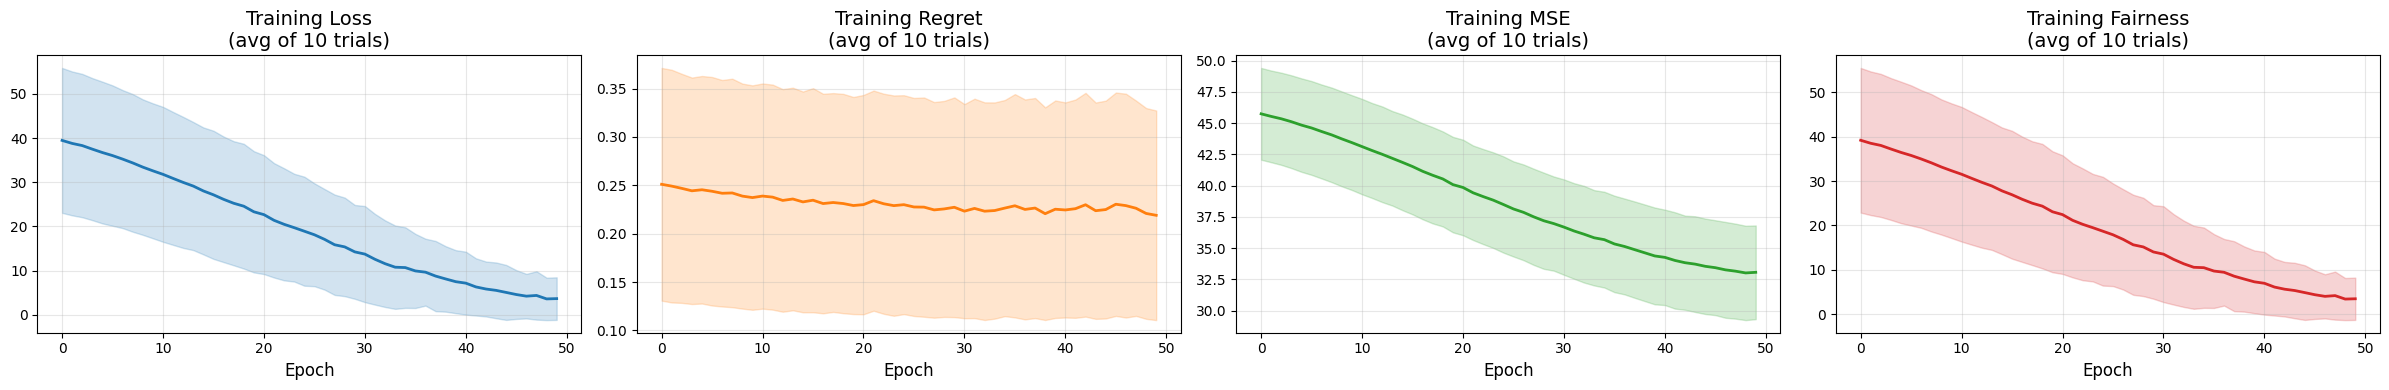

In [47]:
results_2_fair = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=1,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=2,
    Q=1000,
    device="cpu"
)
results_1p5_fair = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=1,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=1.5,
    Q=1000,
    device="cpu"
)
results_0p5_fair = run_multiple_trials_foldopt(
    feats, gainF, risk, cost, df,
    optmodel=solve_closed_form,
    n_trials=10,
    test_size=0.5,
    lambda_fairness=1,
    num_epochs=50,
    lr_pred=1e-3,
    weight_decay=1e-4,
    pgd_lr=1e-2,
    n_fixedpt=200,
    backprop_rule="GMRES",
    alpha=0.5,
    Q=1000,
    device="cpu"
)


In [49]:
results_1p5

{'mean_train_loss': array([0.48996862, 0.48454488, 0.47860537, 0.47174016, 0.46627682,
        0.46210089, 0.45585703, 0.45129933, 0.44621127, 0.44054699,
        0.43560455, 0.42979686, 0.42682703, 0.42158069, 0.41606782,
        0.41158987, 0.40570133, 0.40024409, 0.39574397, 0.38988728,
        0.38722316, 0.38210133, 0.37808026, 0.37150398, 0.36405242,
        0.36417382, 0.3560257 , 0.35371751, 0.34619702, 0.33797003,
        0.3350359 , 0.32855902, 0.32222299, 0.31686868, 0.30737147,
        0.30595446, 0.30028746, 0.29605075, 0.2885227 , 0.2856641 ,
        0.2820625 , 0.27685107, 0.27513929, 0.27457224, 0.27456128,
        0.27333273, 0.26854576, 0.27292009, 0.27383454, 0.27638247]),
 'std_train_loss': array([0.04469439, 0.04508335, 0.04445706, 0.04358138, 0.04233524,
        0.04175363, 0.04124089, 0.04055931, 0.04061432, 0.03954654,
        0.04022812, 0.03821437, 0.03923174, 0.03846734, 0.0399856 ,
        0.03877897, 0.03892047, 0.03904005, 0.03817582, 0.03934775,
        0

In [61]:
results_1p5_fair

{'mean_train_loss': array([39.651299  , 39.07900429, 38.43097696, 37.73196869, 37.05520887,
        36.17399168, 35.35467682, 34.57354088, 33.65066676, 33.03660679,
        32.09011426, 30.87190676, 30.22212739, 29.33373356, 28.24827628,
        27.23308942, 26.57649293, 25.39146841, 24.15956374, 23.4295599 ,
        22.41987758, 21.48739188, 20.83997514, 19.78763608, 18.76052511,
        17.7585757 , 16.72861602, 15.82289301, 14.85424327, 13.89156798,
        13.09729075, 12.2365249 , 11.34920334, 10.24402304,  9.58443924,
         8.34595683,  8.07861429,  7.1257808 ,  6.966318  ,  6.0030952 ,
         5.27841607,  5.27028006,  5.01820911,  4.54003556,  3.78822415,
         3.71109393,  2.62077266,  2.13127629,  1.70403197,  1.31632901]),
 'std_train_loss': array([16.0748378 , 16.04885565, 15.82504376, 15.58988474, 15.62189996,
        15.42697134, 15.39704502, 15.17874015, 15.01816902, 14.85030469,
        14.81431244, 14.60764751, 14.443768  , 14.03002009, 14.01463345,
        13.6

In [62]:
50.48113598823547/50,  0.3410325979513214/50

(1.0096227197647094, 0.006820651959026428)

In [45]:
raise Exception("Stop here")

Exception: Stop here

In [ ]:
predmodel = FairRiskPredictor(feats_train.shape[1]) 
predmodel.to(device) 
 
logs = trainFairModelFoldOpt(
    predmodel,
    dataloader_train,
    dataloader_test,
    alpha=2,
    Q=1000,
    lambda_fairness=1,
    num_epochs=50,
    lr_pred=1e-3
)


Epoch  1 | Loss=80.6166 | MSE=46.7427 | Fair=65.2100 | Regret=15.4066 | 1.8s
Epoch  2 | Loss=79.6057 | MSE=46.4891 | Fair=64.8898 | Regret=14.7158 | 1.7s
Epoch  3 | Loss=78.1984 | MSE=46.2131 | Fair=64.0244 | Regret=14.1740 | 1.8s
Epoch  4 | Loss=77.0356 | MSE=45.9069 | Fair=63.5242 | Regret=13.5114 | 1.7s
Epoch  5 | Loss=75.3810 | MSE=45.5243 | Fair=62.3491 | Regret=13.0318 | 1.7s
Epoch  6 | Loss=73.8940 | MSE=45.2066 | Fair=61.4366 | Regret=12.4574 | 1.7s
Epoch  7 | Loss=72.7015 | MSE=44.9665 | Fair=60.5660 | Regret=12.1355 | 1.7s
Epoch  8 | Loss=70.9922 | MSE=44.5996 | Fair=59.3324 | Regret=11.6598 | 1.7s
Epoch  9 | Loss=71.1390 | MSE=44.3361 | Fair=59.8720 | Regret=11.2671 | 1.7s
Epoch 10 | Loss=68.8645 | MSE=43.9473 | Fair=58.0353 | Regret=10.8292 | 1.7s
Epoch 11 | Loss=67.3669 | MSE=43.6038 | Fair=56.9372 | Regret=10.4296 | 1.7s
Epoch 12 | Loss=65.9796 | MSE=43.3461 | Fair=55.7978 | Regret=10.1819 | 1.7s
Epoch 13 | Loss=64.9208 | MSE=42.9757 | Fair=55.0720 | Regret=9.8488 | 1.7s


In [ ]:
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.to(device)

logs = trainFairModelFoldOpt(
    predmodel,
    dataloader_train,
    dataloader_test,
    alpha=0.5,
    Q=1000,
    lambda_fairness=0,
    num_epochs=20,
    lr_pred=1e-3
)


Epoch  1 | Loss=-2.7220 | MSE=45.3218 | Fair=64.0108 | Regret=-2.7220 | 1.7s
Epoch  2 | Loss=-2.7176 | MSE=45.6041 | Fair=64.2909 | Regret=-2.7176 | 1.7s
Epoch  3 | Loss=-2.7122 | MSE=45.8550 | Fair=64.7790 | Regret=-2.7122 | 1.7s
Epoch  4 | Loss=-2.7073 | MSE=45.9520 | Fair=65.0737 | Regret=-2.7073 | 1.7s
Epoch  5 | Loss=-2.7084 | MSE=46.0793 | Fair=65.1606 | Regret=-2.7084 | 1.7s
Epoch  6 | Loss=-2.7095 | MSE=46.1310 | Fair=65.5823 | Regret=-2.7095 | 1.7s
Epoch  7 | Loss=-2.7092 | MSE=46.0135 | Fair=65.2413 | Regret=-2.7092 | 1.7s
Epoch  8 | Loss=-2.7077 | MSE=45.9870 | Fair=65.4915 | Regret=-2.7077 | 1.7s
Epoch  9 | Loss=-2.7113 | MSE=45.9798 | Fair=65.0195 | Regret=-2.7113 | 1.7s
Epoch 10 | Loss=-2.7097 | MSE=45.9331 | Fair=64.8759 | Regret=-2.7097 | 1.7s
Epoch 11 | Loss=-2.7130 | MSE=45.9604 | Fair=65.2115 | Regret=-2.7130 | 1.7s
Epoch 12 | Loss=-2.7120 | MSE=45.8715 | Fair=65.1391 | Regret=-2.7120 | 1.7s
Epoch 13 | Loss=-2.7089 | MSE=45.8907 | Fair=64.7507 | Regret=-2.7089 | 1.7s

In [ ]:
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_0p5.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_0p5_fair.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_1p5.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_1p5_fair.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_2.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_2_fair.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_inf.pkl
# E:\User\Stevens\MyRepo\FDFL\res\cvxpylayer\LR\results_cvx_inf_fair.pkl